In [2]:
!pip install cupy-cuda101
#!pip install cupy
#!pip install pylops[advanced]
!pip install git+https://github.com/mrava87/pylops@cupy-ext

  Cloning https://github.com/mrava87/pylops (to revision cupy-ext) to /tmp/pip-req-build-jihmdib1
  Running command git clone -q https://github.com/mrava87/pylops /tmp/pip-req-build-jihmdib1
  Running command git checkout -b cupy-ext --track origin/cupy-ext
  Switched to a new branch 'cupy-ext'
  Branch 'cupy-ext' set up to track remote branch 'cupy-ext' from 'origin'.
  Created wheel for pylops: filename=pylops-1.10.1.dev41+g95267f1-cp36-none-any.whl size=154692 sha256=24b225e9470922b95a5d81a9dbc2ce457ff27ccd42f964e042722cc8c7fb41b3
  Stored in directory: /tmp/pip-ephem-wheel-cache-z5samevc/wheels/ee/c6/91/602ea68e6c612f7b41703971525d62bc6270318ac1e29433fa
Successfully built pylops


In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#import warnings
#warnings.filterwarnings('ignore')

import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import scipy as sp

from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc
from scipy.signal import triang

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity      import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Dot test passed, v^T(Opu)=-0.178885 - u^T(Op^Tv)=-0.178885


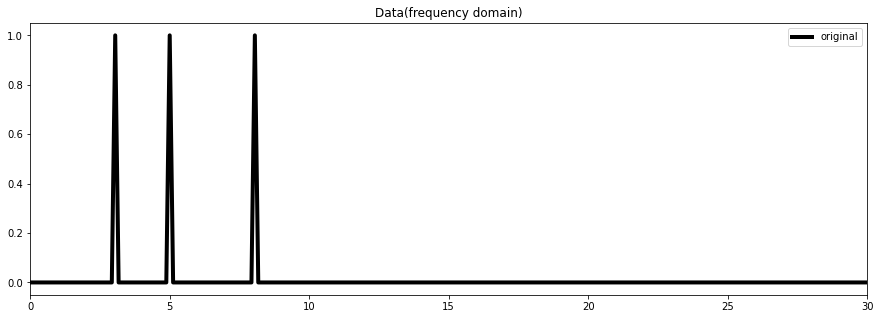

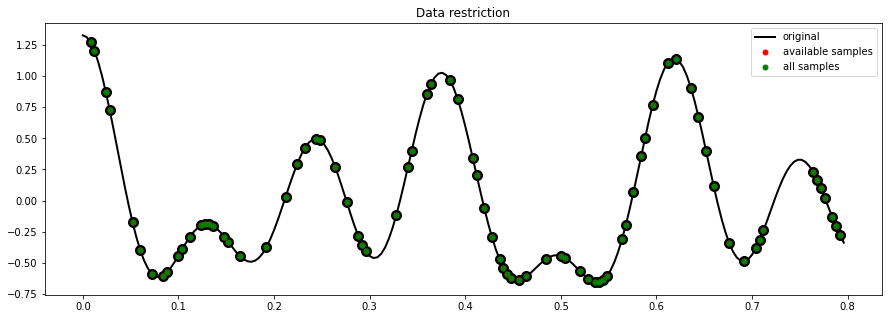

In [ ]:
# Signal creation
N=200
dt=0.004
nfft=2**11
t = np.arange(N)*dt
f = np.fft.rfftfreq(nfft, dt)
ifreqs = [ 41, 25, 66]
freqs = f[ifreqs]

X = cp.zeros(nfft//2+1, dtype='complex128')
X[ifreqs] = 1
FFTop = 10*FFT(N, nfft=nfft, real=True)
x = FFTop.H*X

fig = plt.figure(figsize=(15,5))
plt.plot(f, np.abs(cp.asnumpy(X)), 'k', LineWidth=4,   label='original')
plt.xlim(0,30)
plt.legend()
plt.title('Data(frequency domain)');

# subsampling locations
perc_subsampling=0.4
Nsub=int(np.round(N*perc_subsampling))

iava = np.sort(np.random.permutation(np.arange(N))[:Nsub])

# Create restriction operator
Rop = Restriction(N, iava, dtype='float64')
dottest(Rop,Nsub,N, verb=True, backend='cupy')

y     = Rop*x
ymask = Rop.mask(x)

# Visualize data
fig = plt.figure(figsize=(15,5))
plt.plot(t,       cp.asnumpy(x),       'k' , LineWidth=2,   label='original')
plt.plot(t[iava], cp.asnumpy(x)[iava], '.k', MarkerSize=20)
plt.plot(t[iava], cp.asnumpy(y),       '.r', MarkerSize=10, label='available samples')
plt.plot(t,       ymask,   '.g', MarkerSize=10, label='all samples')
plt.legend()
plt.title('Data restriction');

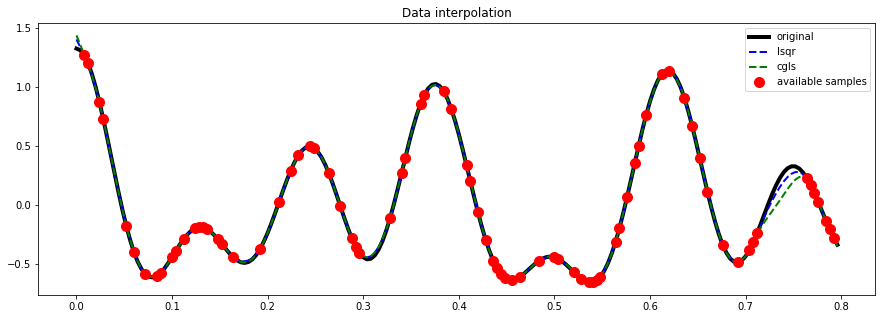

In [ ]:
# Create regularization operator
D2op  = SecondDerivative(N, dims=None, dtype='float64')

# Invert for interpolated signal
xlsqr_reg_lop, istop, itn, r1norm, r2norm = \
    RegularizedInversion(Rop, [D2op], cp.asnumpy(y), epsRs=[np.sqrt(0.1)], returninfo=True,
                         **dict(damp=np.sqrt(1e-4), iter_lim=200, show=0))

xcgls_reg_lop = \
    RegularizedInversion(Rop, [D2op], y, epsRs=[np.sqrt(0.5)], returninfo=False,
                         **dict(damp=np.sqrt(1e-4), niter=200, show=0))

fig = plt.figure(figsize=(15,5))
plt.plot(t,       cp.asnumpy(x),              'k'   , LineWidth=4,   label='original')
plt.plot(t,       cp.asnumpy(xlsqr_reg_lop), '--b' , LineWidth=2,   label='lsqr')
plt.plot(t,       cp.asnumpy(xcgls_reg_lop), '--g' , LineWidth=2,   label='cgls')
plt.plot(t[iava], cp.asnumpy(y),              '.r'  , MarkerSize=20, label='available samples')
plt.legend()
plt.title('Data interpolation');

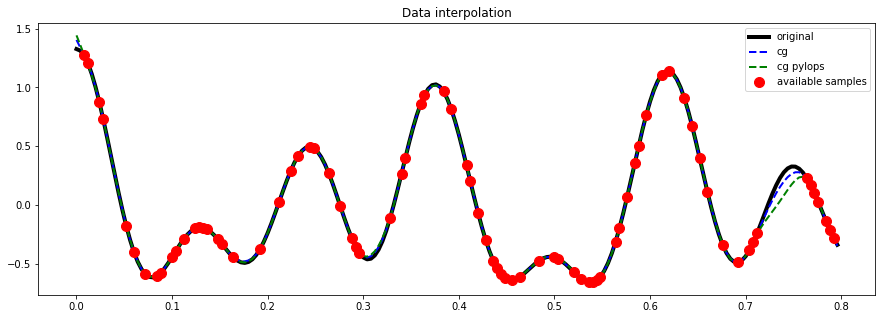

In [ ]:
epsR=np.sqrt(0.1)
epsI=np.sqrt(1e-4)
x_cg_lop, istop = NormalEquationsInversion(Rop, [D2op], cp.asnumpy(y), epsI=epsI, epsRs=[epsR], returninfo=True, 
                                           **dict(maxiter=200))
epsR=np.sqrt(0.4)
epsI=np.sqrt(1e-4)
x_cgls_lop, istop = NormalEquationsInversion(Rop, [D2op], y, epsI=epsI, epsRs=[epsR], returninfo=True, 
                                             **dict(niter=200))

fig = plt.figure(figsize=(15,5))
plt.plot(t,       cp.asnumpy(x),              'k'   , LineWidth=4,   label='original')
plt.plot(t,       x_cg_lop, '--b' , LineWidth=2,   label='cg')
plt.plot(t,       cp.asnumpy(x_cgls_lop), '--g' , LineWidth=2,   label='cg pylops')
plt.plot(t[iava], cp.asnumpy(y),              '.r'  , MarkerSize=20, label='available samples')
plt.legend()
plt.title('Data interpolation');